This notebook provides an introduction to some of the basic concepts of machine learning.

Let's start by generating some data to work with.  Let's say that we have a dataset that has tested people on two continuous measures (processing speed and age) and one discrete measure (diagnosis with any psychiatric disorder).  First let's create the continuous data assuming that there is a relationship between these two variables.  We will make a function to generate a new dataset, since we will need to do this multiple times.

In [20]:
import numpy,pandas
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.preprocessing import PolynomialFeatures,scale
from sklearn.linear_model import LinearRegression,LassoCV,Ridge
import seaborn as sns
import statsmodels.formula.api as sm
from statsmodels.tools.tools import add_constant

recreate=True
if recreate:
    seed=20698
else:
    seed=numpy.ceil(numpy.random.rand()*100000).astype('int')
    print(seed)

numpy.random.seed(seed)

def make_continuous_data(mean=[45,100],var=[10,10],cor=-0.6,N=100):
    """
    generate a synthetic data set with two variables
    """
    cor=numpy.array([[1.,cor],[cor,1.]])
    var=numpy.array([[var[0],0],[0,var[1]]])
    cov=var.dot(cor).dot(var)
    return numpy.random.multivariate_normal(mean,cov,N)

data R-squared: 0.425284


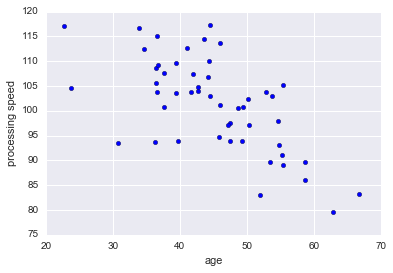

In [21]:
n=50
d=make_continuous_data(N=n)
y=d[:,1]
plt.scatter(d[:,0],d[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')

print('data R-squared: %f'%numpy.corrcoef(d.T)[0,1]**2)

What is the simplest story that we could tell about processing speed these data?  Well, we could simply say that the variable is normal with a mean of zero and a standard deviation of 1.  Let's see how likely the observed processing speed values are given that set of parameters.  First, let's create a function that returns the normal log-likelihood of the data given a set of predicted values.


In [22]:
def loglike(y,yhat,s2=None,verbose=True):
    N = len(y)
    SSR = numpy.sum((y-yhat)**2)
    if s2 is None:
        # use observed stdev
        s2 = SSR / float(N)
    logLike = -(n/2.)*numpy.log(s2) - (n/2.)*numpy.log(2*numpy.pi) - SSR/(2*s2)
    if verbose:
        print('SSR:',SSR)
        print('s2:',s2)
        print('logLike:',logLike)
    return logLike
    

logLike_null=loglike(y,numpy.zeros(len(y)),s2=1)


SSR: 517834.563479
s2: 1
logLike: -258963.228666


We are pretty sure that the mean of our variables is not zero, so let's compute the mean and see if the likelihood of the data is higher.

In [23]:
mean=numpy.mean(y)
print('mean:',mean)
pred=numpy.ones(len(y))*mean
logLike_mean=loglike(y,pred,s2=1)


mean: 101.342983342
SSR: 4314.54984688
s2: 1
logLike: -2203.2218501


What about using the observed variance as well?

In [24]:
var=numpy.var(y)
print('variance',var)
pred=numpy.ones(len(y))*mean
logLike_mean_std=loglike(y,pred)


variance 86.2909969376
SSR: 4314.54984688
s2: 86.2909969376
logLike: -182.390058405


Is there a relation between processing speed and age? Compute the linear regression equation to find out. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     35.52
Date:                Thu, 22 Dec 2016   Prob (F-statistic):           2.89e-07
Time:                        09:07:56   Log-Likelihood:                -168.54
No. Observations:                  50   AIC:                             341.1
Df Residuals:                      48   BIC:                             344.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        131.3701      5.140     25.560      0.0

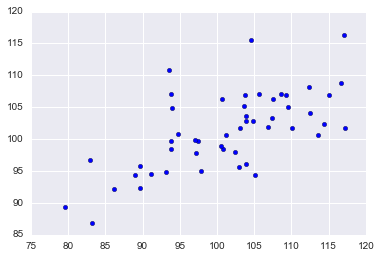

In [25]:
X=d[:,0]
X=add_constant(X)
result = sm.OLS( y, X ).fit()
print(result.summary())
intercept=result.params[0]
slope=result.params[1]
pred=result.predict(X)
logLike_ols=loglike(y,pred)
plt.scatter(y,pred)

processing speed = 131.370054 + -0.666591*age
p =0.000000
rsquared=0.425284


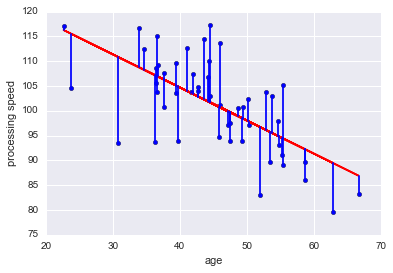

In [26]:
print('processing speed = %f + %f*age'%(intercept,slope))
print('p =%f'%result.pvalues[1])

def get_RMSE(y,pred):
    return numpy.sqrt(numpy.mean((y - pred)**2))

def get_R2(y,pred):
    """ compute r-squared"""
    return numpy.corrcoef(y,pred)[0,1]**2

ax=plt.scatter(d[:,0],d[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')
plt.plot(d[:,0], slope * d[:,0] + intercept, color='red')
# plot residual lines
d_predicted=slope*d[:,0] + intercept
for i in range(d.shape[0]):
    x=d[i,0]
    y=d[i,1]
    plt.plot([x,x],[d_predicted[i],y],color='blue')

RMSE=get_RMSE(d[:,1],d_predicted)
rsq=get_R2(d[:,1],d_predicted)
print('rsquared=%f'%rsq)

This shows us that linear regression can provide a simple description of a complex dataset - we can describe the entire dataset in 2 numbers. Now let's ask how good this description is for a new dataset generated by the same process:


R2 for new data: 0.376184


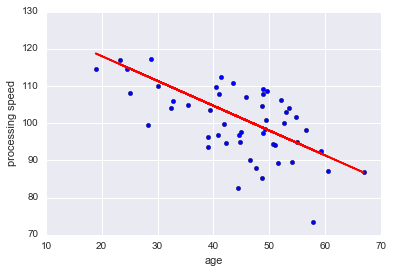

In [27]:
d_new=make_continuous_data(N=n)
d_new_predicted=intercept + slope*d_new[:,0]
RMSE_new=get_RMSE(d_new[:,1],d_new_predicted)
rsq_new=get_R2(d_new[:,1],d_new_predicted)
print('R2 for new data: %f'%rsq_new)

ax=plt.scatter(d_new[:,0],d_new[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')
plt.plot(d_new[:,0], slope * d_new[:,0] + intercept, color='red')


Now let's do this 100 times and look at how variable the fits are.  

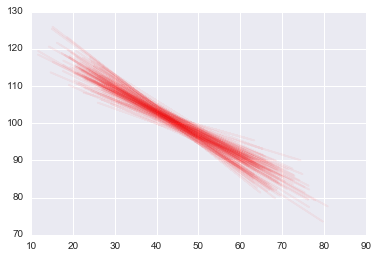

In [28]:
nruns=100
slopes=numpy.zeros(nruns)
intercepts=numpy.zeros(nruns)
rsquared=numpy.zeros(nruns)

fig = plt.figure()
ax = fig.gca()

for i in range(nruns):
    data=make_continuous_data(N=n)
    slopes[i],intercepts[i],_,_,_=scipy.stats.linregress(data[:,0],data[:,1])
    ax.plot(data[:,0], slopes[i] * data[:,0] + intercepts[i], color='red', alpha=0.05)
    pred_orig=intercept + slope*data[:,0]
    rsquared[i]=get_R2(data[:,1],pred_orig)


In [29]:
print('Original R2: %f'%rsq)
print('Mean R2 for new datasets on original model: %f'%numpy.mean(rsquared))


Original R2: 0.425284
Mean R2 for new datasets on original model: 0.373708


### Cross-validation

The results above show that the fit of the model to the observed data overestimates our ability to predict on new data.  In many cases we would like to be able to quantify how well our model generalizes to new data, but it's often not possible to collect additional data.  The concept of *cross-validation* provides us with a way to measure how well a model generalizes.  The idea is to iteratively train the model on subsets of the data and then test the model on the left-out portion.  Let's first see what cross-validation looks like.  Perhaps the simplest version to understand is "leave-one-out" crossvalidation, so let's look at that.  Here is what the training and test datasets would look like for a dataset with 10 observations; in reality this is way too few observations, but we will use it as an exmaple

In [30]:
# initialize the sklearn leave-one-out operator
loo=LeaveOneOut()  

for train,test in loo.split(range(10)):
    print('train:',train,'test:',test)

train: [1 2 3 4 5 6 7 8 9] test: [0]
train: [0 2 3 4 5 6 7 8 9] test: [1]
train: [0 1 3 4 5 6 7 8 9] test: [2]
train: [0 1 2 4 5 6 7 8 9] test: [3]
train: [0 1 2 3 5 6 7 8 9] test: [4]
train: [0 1 2 3 4 6 7 8 9] test: [5]
train: [0 1 2 3 4 5 7 8 9] test: [6]
train: [0 1 2 3 4 5 6 8 9] test: [7]
train: [0 1 2 3 4 5 6 7 9] test: [8]
train: [0 1 2 3 4 5 6 7 8] test: [9]


It is often more common to use larger test folds, both to speed up performance (since LOO can require lots of model fitting when there are a large number of observations) and because LOO error estimates can have high variance due to the fact that the models are so highly correlated.  This is referred to as K-fold cross-validation; generally we want to choose K somewhere around 5-10.  It's generally a good idea to shuffle the order of the observations so that the folds are grouped randomly.

In [31]:
# initialize the sklearn leave-one-out operator
kf=KFold(n_splits=5,shuffle=True)  

for train,test in kf.split(range(10)):
    print('train:',train,'test:',test)

train: [0 2 3 5 6 7 8 9] test: [1 4]
train: [0 1 3 4 5 6 7 9] test: [2 8]
train: [0 1 2 3 4 5 7 8] test: [6 9]
train: [0 1 2 4 5 6 8 9] test: [3 7]
train: [1 2 3 4 6 7 8 9] test: [0 5]


Now let's perform leave-one-out cross-validation on our original dataset, so that we can compare it to the performance on new datasets.  We expect that the correlation between LOO estimates and actual data should be very similar to the Mean R2 for new datasets.  We can also plot a histogram of the estimates, to see how they vary across folds.

R2 for leave-one-out prediction: 0.263661


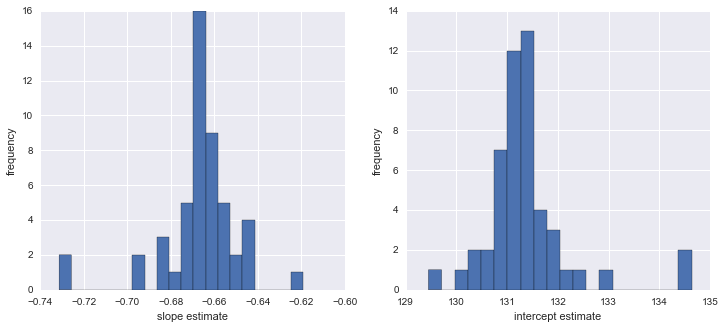

In [32]:
loo=LeaveOneOut()

slopes_loo=numpy.zeros(n)
intercepts_loo=numpy.zeros(n)
pred=numpy.zeros(n)

ctr=0
for train,test in loo.split(range(n)):
    slopes_loo[ctr],intercepts_loo[ctr],_,_,_=scipy.stats.linregress(d[train,0],d[train,1])
    pred[ctr]=intercepts_loo[ctr] + slopes_loo[ctr]*data[test,0]
    ctr+=1

print('R2 for leave-one-out prediction: %f'%get_R2(pred,data[:,1]))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
_=plt.hist(slopes_loo,20)
plt.xlabel('slope estimate')
plt.ylabel('frequency')
plt.subplot(1,2,2)
_=plt.hist(intercepts_loo,20)
plt.xlabel('intercept estimate')
plt.ylabel('frequency')


Now let's look at the effect of outliers on in-sample correlation and out-of-sample prediction.


R2 for regression with outlier: 0.740741
R2 for leave-one-out prediction: 0.001384


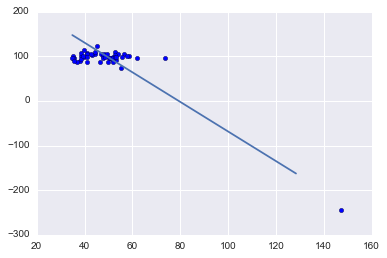

In [33]:
# add an outlier
data_null=make_continuous_data(N=n,cor=0.0)
outlier_multiplier=2.0

data=numpy.vstack((data_null,[numpy.max(data_null[:,0])*outlier_multiplier,
                         numpy.max(data_null[:,1])*outlier_multiplier*-1]))
plt.scatter(data[:,0],data[:,1])
slope,intercept,r,p,se=scipy.stats.linregress(data[:,0],data[:,1])
plt.plot([numpy.min(data[:,0]),intercept + slope*numpy.min(data[:,0])],
         [numpy.max(data[:,0]),intercept + slope*numpy.max(data[:,0])])
rsq_outlier=r**2
print('R2 for regression with outlier: %f'%rsq_outlier)

loo=LeaveOneOut()

pred_outlier=numpy.zeros(data.shape[0])

ctr=0
for train,test in loo.split(range(data.shape[0])):
    s,i,_,_,_=scipy.stats.linregress(data[train,0],data[train,1])
    pred_outlier[ctr]=i + s*data[test,0]
    ctr+=1

print('R2 for leave-one-out prediction: %f'%get_R2(pred_outlier,data[:,1]))

### Model selection

Often when we are fitting models to data we have to make decisions about the complexity of the model; after all, if the model has as many parameters as there are data points then we can fit the data exactly, but as we saw above, this model will not generalize very well to other datasets.


To see how we can use cross-validation to select our model complexity, let's generate some data with a certain polynomial order, and see whether crossvalidation can find the right model order.  

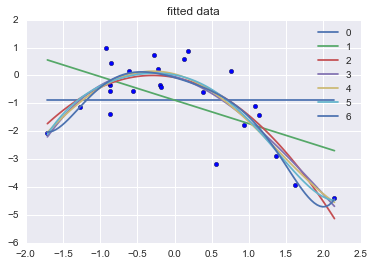

In [34]:
# from https://gist.github.com/iizukak/1287876
def gram_schmidt_columns(X):
    Q, R = numpy.linalg.qr(X)
    return Q

def make_continuous_data_poly(mean=0,var=1,betaval=5,order=1,N=100):
    """
    generate a synthetic data set with two variables
    allowing polynomial functions up to 5-th order
    """
    x=numpy.random.randn(N)
    x=x-numpy.mean(x)
    pf=PolynomialFeatures(5,include_bias=False)

    x_poly=gram_schmidt_columns(pf.fit_transform(x[:,numpy.newaxis]))

    betas=numpy.zeros(5)
    betas[0]=mean
    for i in range(order):
        betas[i]=betaval
    func=x_poly.dot(betas)+numpy.random.randn(N)*var
    d=numpy.vstack((x,func)).T
    return d,x_poly

n=25
trueorder=2
data,x_poly=make_continuous_data_poly(N=n,order=trueorder)

# fit models of increasing complexity
npolyorders=7

plt.figure()
plt.scatter(data[:,0],data[:,1])
plt.title('fitted data')

xp=numpy.linspace(numpy.min(data[:,0]),numpy.max(data[:,0]),100)

for i in range(npolyorders):
    f = numpy.polyfit(data[:,0], data[:,1], i)
    p=numpy.poly1d(f)
    plt.plot(xp,p(xp))
plt.legend(['%d'%i for i in range(npolyorders)])

# compute in-sample and out-of-sample error using LOO
loo=LeaveOneOut()
pred=numpy.zeros((n,npolyorders))
mean_trainerr=numpy.zeros(npolyorders)
prederr=numpy.zeros(npolyorders)

for i in range(npolyorders):
    ctr=0
    trainerr=numpy.zeros(n)
    for train,test in loo.split(range(data.shape[0])):
        f = numpy.polyfit(data[train,0], data[train,1], i)
        p=numpy.poly1d(f)
        trainerr[ctr]=numpy.sqrt(numpy.mean((data[train,1]-p(data[train,0]))**2))
        pred[test,i]=p(data[test,0])
        ctr+=1
    mean_trainerr[i]=numpy.mean(trainerr)
    prederr[i]=numpy.sqrt(numpy.mean((data[:,1]-pred[:,i])**2))
    

True order: 2
Order estimated by cross validation: 2


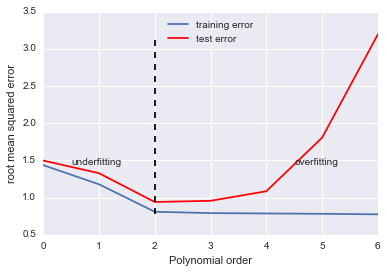

In [35]:
plt.plot(range(npolyorders),mean_trainerr)
plt.plot(range(npolyorders),prederr,color='red')
plt.xlabel('Polynomial order')
plt.ylabel('root mean squared error')
plt.legend(['training error','test error'],loc=9)
plt.plot([numpy.argmin(prederr),numpy.argmin(prederr)],
         [numpy.min(mean_trainerr),numpy.max(prederr)],'k--')
plt.text(0.5,numpy.max(mean_trainerr),'underfitting')
plt.text(4.5,numpy.max(mean_trainerr),'overfitting')

print('True order:',trueorder)
print('Order estimated by cross validation:',numpy.argmin(prederr))

### Bias-variance tradeoffs

Another way to think about model complexity is in terms of bias-variance tradeoffs.  Bias is the average distance between the prediction of our model and the correct value, whereas variance is the average distance between different predictions from the model.  In standard statistics classes it is often taken as a given that an unbiased estimate is always best, but within machine learning we will often see that a bit of bias can go a long way towards reducing variance, and that some kinds of bias make particular sense.

Let's start with an example using linear regression.  First, we will generate a dataset with 20 variables and 100 observations, but only two of the variables are actually related to the outcome (the rest are simply random noise).  

In [36]:
def make_larger_dataset(beta,n,sd=1):
    X=numpy.random.randn(n,len(beta)) # design matrix
    beta=numpy.array(beta)
    y=X.dot(beta)+numpy.random.randn(n)*sd
    return(y-numpy.mean(y),X)
    

Now let's fit two different models to the data that we will generate.  First, we will fit a standard linear regression model, using ordinary least squares.  This is the best linear unbiased estimator for the regression model.  We will also fit a model that uses *regularization*, which places some constraints on the parameter estimates. In this case, we use the Lasso model, which minimizes the sum of squares while also constraining (or *penalizing*) the sum of the absolute parameter estimates (known as an L1 penalty).  The parameter estimates of this model will be biased towards zero, and will be *sparse*, meaning that most of the estimates will be exactly zero.

One complication of the Lasso model is that we need to select a value for the alpha parameter, which determines how much penalty there will be.  We will use crossvalidation within the training data set to do this; the sklearn LassoCV() function does it for us automatically.  Let's generate a function that can run both standard regression and Lasso regression.

In [37]:
def compare_lr_lasso(n=100,nvars=20,n_splits=8,sd=1):
    beta=numpy.zeros(nvars)
    beta[0]=1
    beta[1]=-1
    y,X=make_larger_dataset(beta,100,sd=1)
    
    kf=KFold(n_splits=n_splits,shuffle=True)
    pred_lr=numpy.zeros(X.shape[0])
    coefs_lr=numpy.zeros((n_splits,X.shape[1]))
    pred_lasso=numpy.zeros(X.shape[0])
    coefs_lasso=numpy.zeros((n_splits,X.shape[1]))
    lr=LinearRegression()
    lasso=LassoCV()
    ctr=0
    for train,test in kf.split(X):
        Xtrain=X[train,:]
        Ytrain=y[train]
        lr.fit(Xtrain,Ytrain)
        lasso.fit(Xtrain,Ytrain)
        pred_lr[test]=lr.predict(X[test,:])
        coefs_lr[ctr,:]=lr.coef_
        pred_lasso[test]=lasso.predict(X[test,:])
        coefs_lasso[ctr,:]=lasso.coef_
        ctr+=1
    prederr_lr=numpy.sum((pred_lr-y)**2)
    prederr_lasso=numpy.sum((pred_lasso-y)**2)
    return [prederr_lr,prederr_lasso],numpy.mean(coefs_lr,0),numpy.mean(coefs_lasso,0),beta



Let's run the simulation 100 times and look at the average parameter estimates.

In [38]:
nsims=100
prederr=numpy.zeros((nsims,2))
lrcoef=numpy.zeros((nsims,20))
lassocoef=numpy.zeros((nsims,20))

for i in range(nsims):
    prederr[i,:],lrcoef[i,:],lassocoef[i,:],beta=compare_lr_lasso()
    
print('mean sum of squared error:')
print('linear regression:',numpy.mean(prederr,0)[0])
print('lasso:',numpy.mean(prederr,0)[1])

/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


mean sum of squared error:
linear regression: 128.04471132
lasso: 109.413542654


The prediction error for the Lasso model is substantially less than the error for the linear regression model.  What about the parameters? Let's display the mean parameter estimates and their variabilty across runs.

In [39]:
coefs_df=pandas.DataFrame({'True value':beta,'Regression (mean)':numpy.mean(lrcoef,0),'Lasso (mean)':numpy.mean(lassocoef,0),
                          'Regression(stdev)':numpy.std(lrcoef,0),'Lasso(stdev)':numpy.std(lassocoef,0)})
coefs_df

,Lasso (mean),Lasso(stdev),Regression (mean),Regression(stdev),True value
0,0.872333,0.090229,1.008043,0.108360,1.0
1,-0.867128,0.112791,-1.008489,0.118108,-1.0
2,0.001801,0.035974,0.012622,0.112245,0.0
3,0.002453,0.040318,-0.007810,0.120471,0.0
4,-0.003408,0.034733,-0.000104,0.123107,0.0
5,0.003916,0.037916,0.017360,0.121194,0.0
6,0.000010,0.040394,0.008228,0.121575,0.0
7,0.001843,0.039537,-0.001793,0.123341,0.0
8,-0.002537,0.036670,-0.009299,0.114992,0.0
9,0.003919,0.049977,-0.000174,0.132553,0.0


Another place where regularization is essential is when your data are wider than they are tall - that is, when you have more variables than observations. This is almost always the case for brain imaging data, when the number of voxels far outweighs the number of subjects or events.  In this case, the ordinary least squares solution is ill-posed, meaning that it has an infinite number of possible solutions.  The sklearn LinearRegression() estimator will return an estimate even in this case, but the parameter estimates will be highly variable.  However, we can use a regularized regression technique to find more robust estimates in this case.  

Let's run the same simulation, but now put 1000 variables instead of 20. This will take a few minutes to execute.  

In [40]:
nsims=100
prederr=numpy.zeros((nsims,2))
lrcoef=numpy.zeros((nsims,1000))
lassocoef=numpy.zeros((nsims,1000))

for i in range(nsims):
    prederr[i,:],lrcoef[i,:],lassocoef[i,:],beta=compare_lr_lasso(nvars=1000)
    
print('mean sum of squared error:')
print('linear regression:',numpy.mean(prederr,0)[0])
print('lasso:',numpy.mean(prederr,0)[1])


/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


mean sum of squared error:
linear regression: 298.858870008
lasso: 131.318485625
